In [370]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [371]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [372]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [373]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 7 2022 9:05AM,10,"Snap Medical Industries, LLC",Receiving,Yulieth Aguirre,9
1,Apr 7 2022 9:05AM,10,"Snap Medical Industries, LLC",Receiving,Yulieth Aguirre,9
2,Apr 7 2022 9:05AM,10,"Snap Medical Industries, LLC",Receiving,Yulieth Aguirre,9
3,Apr 7 2022 7:22AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7
4,Apr 7 2022 7:22AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7


# WAREHOUSE

In [374]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,1478
1,12,39
2,15,206
3,16,77
4,17,308


In [375]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [376]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [377]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,1478
12,39
15,206
16,77
17,308


### All Operations type

In [378]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,134
1,Count,141
2,Create Inventory,8
3,DONE RECEIVING,12
4,DRIVER CHECK IN,10


In [379]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [380]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,134
1,Count,141
2,Create Inventory,8
3,DONE RECEIVING,12
4,DRIVER CHECK IN,10


In [381]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,134
Count,141
Create Inventory,8
DONE RECEIVING,12
DRIVER CHECK IN,10


### Excluding Operations PICKING and RECEIVING

In [382]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [383]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,134
Count,141
Create Inventory,8
DONE RECEIVING,12
DRIVER CHECK IN,10


### Operations per Hour

In [384]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,7,74
1,8,230
2,9,642
3,10,894
4,11,777


In [385]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [386]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
7,74
8,230
9,642
10,894
11,777


# PICKING

In [387]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [388]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,7,1
1,Aisha Cooper,8,12
2,Aisha Cooper,9,4
3,Aisha Cooper,10,2
4,Aisha Cooper,11,2


In [389]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10,11,12,13,14,15
employee,,,,,,,,,
Aisha Cooper,1.0,12.0,4.0,2.0,2.0,17.0,14.0,1.0,8.0
Angel Luna,0.0,2.0,20.0,17.0,11.0,9.0,10.0,28.0,13.0
Angela Pena,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Brad Bacchetti,0.0,3.0,12.0,5.0,1.0,17.0,18.0,12.0,22.0
Carl Ambroise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0


### Save in JSON File

In [390]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Angel Luna,Angela Pena,Brad Bacchetti,Carl Ambroise,Carlos Gomez,Danielle Lucas,Doris Hincapie,Edilberto Souza,Edwin Perez,...,Rita Geldres,Sandra Vega,Shawn Saunders,Sujelin Soto-Orta,Thalia Rivera,Wayne Gray,Wendy Medrano,William Trevino Trevino,Yaima Castillo,yudisel tubella
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
8,12.0,2.0,0.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,...,9.0,0.0,8.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
9,4.0,20.0,0.0,12.0,0.0,18.0,19.0,0.0,9.0,0.0,...,15.0,0.0,13.0,0.0,1.0,0.0,16.0,17.0,0.0,0.0
10,2.0,17.0,0.0,5.0,0.0,25.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0
11,2.0,11.0,0.0,1.0,0.0,8.0,0.0,1.0,13.0,0.0,...,0.0,0.0,10.0,0.0,0.0,27.0,9.0,0.0,5.0,7.0


### Picking By Warehouse Function

In [391]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [392]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [393]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 7 2022 9:05AM,10,"Snap Medical Industries, LLC",Receiving,Yulieth Aguirre,9
1,Apr 7 2022 9:05AM,10,"Snap Medical Industries, LLC",Receiving,Yulieth Aguirre,9
2,Apr 7 2022 9:05AM,10,"Snap Medical Industries, LLC",Receiving,Yulieth Aguirre,9
3,Apr 7 2022 7:22AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7
4,Apr 7 2022 7:22AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7


In [394]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Brad Bacchetti,8,2
1,Brad Bacchetti,10,11
2,Brad Bacchetti,13,12
3,Brad Bacchetti,14,2
4,Carl Ambroise,13,12


In [395]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,7,8,9,10,11,12,13,14,15
employee,,,,,,,,,
Brad Bacchetti,0.0,2.0,0.0,11.0,0.0,0.0,12.0,2.0,0.0
Carl Ambroise,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,0.0
Carlos Chavez,0.0,0.0,0.0,0.0,0.0,15.0,6.0,0.0,0.0
Chris Martin,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Djenyson Sanon,0.0,0.0,36.0,23.0,7.0,8.0,4.0,0.0,0.0


In [396]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Brad Bacchetti,Carl Ambroise,Carlos Chavez,Chris Martin,Djenyson Sanon,Ernest Ferguson,John Puskarik,Juan Morales,Justin Runsdorf,Luci Nicley,Martha Hurtado,Omar Robles,Thalia Rivera,Yulieth Aguirre
7,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
10,11.0,0.0,0.0,0.0,23.0,5.0,0.0,12.0,0.0,7.0,2.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,7.0,19.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0


# INVENTORY

In [397]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [398]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [399]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [400]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [401]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,15,19,20,21
operationCode,,,,,
Inventory Counts,58.0,9.0,31.0,43.0,0.0
Inventory Adjustments,7.0,0.0,1.0,2.0,18.0
Discrepancies,0.0,0.0,1.0,2.0,0.0


# QUERY 02: Open Outbounds

In [402]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [403]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [404]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1716 days 06:18:52.375737
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,920 days 04:37:51.429737
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,874 days 22:51:16.779737
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,806 days 02:07:48.509737
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,806 days 02:07:48.125737


In [405]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1716 days 06:18:52.375737,1716,6
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,920 days 04:37:51.429737,920,4
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,874 days 22:51:16.779737,874,22
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,806 days 02:07:48.509737,806,2
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,806 days 02:07:48.125737,806,2


In [406]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [407]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [408]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [409]:
df_02_grouped

,orders
age_group,
24 Hours,767
48 Hours,164
72 Hours,202
1 Week,299
1 Month,1096
2 Months,656
3 Months,576
1 Year,2243
2 Years,1070


### Save in JSON File

In [410]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,767
48 Hours,164
72 Hours,202
1 Week,299
1 Month,1096
2 Months,656
3 Months,576
1 Year,2243
2 Years,1070


<AxesSubplot:ylabel='age_group'>

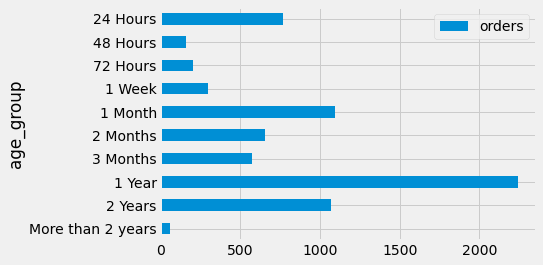

In [411]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance (Orders and Waves)

In [412]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location, o.orderClassId\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
        inner join datex_footprint.ShipmentOrderLookup sol\
        inner join datex_footprint.orders o\
            on o.id = sol.orderId\
            on sol.shipmentId = s.id\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.actualSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2 and isnull(o.orderClassId, 0) not in (23, 24, 36) and s.lookupCode not like '%TEST%'\
    and t.operationCodeId in (8, 39, 2064, 2065, 2066, 2067, 2068) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [413]:
df03.tail(3)

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location,orderClassId
2593,2022-04-07 10:10:44.683,Picking,12,Twinlab Consolidated Corporation,5323,Doris Hincapie,WWW44418,233499,8,.02-06-01-A,2
2594,2022-04-07 10:11:14.683,Picking Completed,12,Twinlab Consolidated Corporation,None,Doris Hincapie,WWW44418,233499,8,None,2
2595,2022-04-07 11:30:34.567,Rate And Ship,12,Twinlab Consolidated Corporation,None,Doris Hincapie,WWW44418,233499,8,None,2


In [414]:
# Order Columns
df03 = df03[['Warehouse', 'Project', 'Wave', 'Shipment', 'Date', 'Operation', 'Employee',
             'Location', 'shipmentsCount', 'Material']]

### Filter by Shipments

In [415]:
# Filter by Orders only
df03_orders = df03.loc[(df03['Operation']=='Picking') |
                       (df03['Operation']=='Scanned Shipment') |
                       (df03['Operation']=='Picking Completed')]

df03_orders = df03_orders[['Warehouse', 'Project', 'Shipment', 'Date', 'Operation', 'Employee', 'Location']]

df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location
0,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None
1,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B
2,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33
3,10,ISDIN Corporation,0085553655,2022-04-07 11:15:59.077,Picking Completed,Hugo Gonzales,None
4,10,ISDIN Corporation,0085553656,2022-04-07 11:23:50.963,Scanned Shipment,Hugo Gonzales,None


In [416]:
# Create a new column with the time difference between rows
df03_orders['PickingTime'] = df03_orders['Date'].diff()
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime
0,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,NaT
1,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000
2,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000
3,10,ISDIN Corporation,0085553655,2022-04-07 11:15:59.077,Picking Completed,Hugo Gonzales,None,0 days 00:00:30
4,10,ISDIN Corporation,0085553656,2022-04-07 11:23:50.963,Scanned Shipment,Hugo Gonzales,None,0 days 00:07:51.886000


In [417]:
# Add Hour, Minute and Second columns
df03_orders['hour'] = df03_orders['PickingTime'].dt.components['hours']
df03_orders['minute'] = df03_orders['PickingTime'].dt.components['minutes']
df03_orders['second'] = df03_orders['PickingTime'].dt.components['seconds']
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,NaT,NaN,NaN,NaN
1,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0
2,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000,0.0,1.0,5.0
3,10,ISDIN Corporation,0085553655,2022-04-07 11:15:59.077,Picking Completed,Hugo Gonzales,None,0 days 00:00:30,0.0,0.0,30.0
4,10,ISDIN Corporation,0085553656,2022-04-07 11:23:50.963,Scanned Shipment,Hugo Gonzales,None,0 days 00:07:51.886000,0.0,7.0,51.0


In [418]:
# Set all the Scanned Shipment hour, minute, time to ZERO
df03_orders_modified = df03_orders

df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'hour'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'minute'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'second'] = 0.0

df03_orders_modified.loc[df03_orders_modified['Operation'] == 'Scanned Shipment'].head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,NaT,0.0,0.0,0.0
4,10,ISDIN Corporation,0085553656,2022-04-07 11:23:50.963,Scanned Shipment,Hugo Gonzales,None,0 days 00:07:51.886000,0.0,0.0,0.0
11,10,ISDIN Corporation,0085579126,2022-04-07 08:31:33.813,Scanned Shipment,Liliana Puentes,None,-1 days +21:00:56.790000,0.0,0.0,0.0
32,10,ISDIN Corporation,0085583714,2022-04-07 11:10:02.947,Scanned Shipment,Wayne Gray,None,0 days 01:35:34.154000,0.0,0.0,0.0
62,10,ISDIN Corporation,0085585045,2022-04-07 09:18:02.860,Scanned Shipment,Rita Geldres,None,-1 days +21:22:30.040000,0.0,0.0,0.0


In [419]:
df03_orders_modified['Time'] = df03_orders_modified['hour']*60 + df03_orders_modified['minute'] + df03_orders_modified['second']/60
df03_orders_modified.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
0,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,NaT,0.0,0.0,0.0,0.000000
1,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0,1.066667
2,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000,0.0,1.0,5.0,1.083333
3,10,ISDIN Corporation,0085553655,2022-04-07 11:15:59.077,Picking Completed,Hugo Gonzales,None,0 days 00:00:30,0.0,0.0,30.0,0.500000
4,10,ISDIN Corporation,0085553656,2022-04-07 11:23:50.963,Scanned Shipment,Hugo Gonzales,None,0 days 00:07:51.886000,0.0,0.0,0.0,0.000000


In [420]:
# Save in JSON Format for HTML
df03_group = df03_orders_modified.groupby(['Warehouse', 'Project', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Shipment', 'Date'])
df03_group.to_json('data/performance.json', orient='table')
df03_group.head(20)

Time
Warehouse Project                  Shipment   Operation         Date                             
10        ACI Healthcare USA, Inc. 7848904-FL Picking           2022-04-07 09:27:56.217  0.683333
                                              Picking Completed 2022-04-07 09:28:26.217  0.500000
                                   7857634    Scanned Shipment  2022-04-07 12:43:27.177  0.000000
                                              Picking           2022-04-07 12:47:16.793  3.816667
                                                                2022-04-07 12:49:43.143  2.433333
                                                                2022-04-07 12:49:54.957  0.183333
                                              Picking Completed 2022-04-07 12:50:24.957  0.500000
          Amatheon Pharmaceuticals SO0368736  Scanned Shipment  2022-04-07 08:54:21.660  0.000000
                                              Picking           2022-04-07 08:54:44.837  0.383333
                                              Picking Completed 2022-04-07 08:55:14.837  0.500000
                                   SO0369688  Scanned Shipment  2022-04-07 11:03:51.533  0.000000
                                              Picking           2022-04-07 11:04:11.317  0.316667
                                                                2022-04-07 11:06:59.383  2.800000
                                                                2022-04-07 11:11:29.327  4.483333
                                                                2022-04-07 11:11:45.983  0.266667
                                                                2022-04-07 11:14:26.230  2.666667
                                                                2022-04-07 11:20:23.117  5.933333
                                                                2022-04-07 11:22:58.527  2.583333
                                                                2022-04-07 11:25:20.687  2.366667
                                                                2022-04-07 11:27:17.797  1.950000

In [421]:
# Remove Operation 'Scanned Shipment'
df03_excluding_Scanned = df03_orders_modified.loc[df03_orders_modified['Operation'] != 'Scanned Shipment']
df03_excluding_Scanned.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
1,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0,1.066667
2,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000,0.0,1.0,5.0,1.083333
3,10,ISDIN Corporation,0085553655,2022-04-07 11:15:59.077,Picking Completed,Hugo Gonzales,None,0 days 00:00:30,0.0,0.0,30.0,0.500000
5,10,ISDIN Corporation,0085553656,2022-04-07 11:24:59.983,Picking,Hugo Gonzales,33-08-01-A,0 days 00:01:09.020000,0.0,1.0,9.0,1.150000
6,10,ISDIN Corporation,0085553656,2022-04-07 11:25:49.640,Picking,Hugo Gonzales,33-05-01-B,0 days 00:00:49.657000,0.0,0.0,49.0,0.816667


In [422]:
# Save in CSV Format for Tableau
df03_group2 = df03_excluding_Scanned.groupby(['Warehouse', 'Project', 'Employee', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Employee', 'Shipment', 'Date'])
df03_group2.to_csv('data/performance.csv')
df03_group2.head(20)

Time
Warehouse Project                  Employee       Shipment   Operation         Date                             
10        ACI Healthcare USA, Inc. Carlos Gomez   7857634    Picking           2022-04-07 12:47:16.793  3.816667
                                                                               2022-04-07 12:49:43.143  2.433333
                                                                               2022-04-07 12:49:54.957  0.183333
                                                             Picking Completed 2022-04-07 12:50:24.957  0.500000
                                   Thalia Rivera  7848904-FL Picking           2022-04-07 09:27:56.217  0.683333
                                                             Picking Completed 2022-04-07 09:28:26.217  0.500000
          Amatheon Pharmaceuticals Carlos Gomez   TO0000240  Picking           2022-04-07 14:35:33.060  6.433333
                                                                               2022-04-07 14:40:43.447  5.166667
                                   Nelson Hurtado SO0368736  Picking           2022-04-07 08:54:44.837  0.383333
                                                             Picking Completed 2022-04-07 08:55:14.837  0.500000
                                                  SO0369688  Picking           2022-04-07 11:04:11.317  0.316667
                                                                               2022-04-07 11:06:59.383  2.800000
                                                                               2022-04-07 11:11:29.327  4.483333
                                                                               2022-04-07 11:11:45.983  0.266667
                                                                               2022-04-07 11:14:26.230  2.666667
                                                                               2022-04-07 11:20:23.117  5.933333
                                                                               2022-04-07 11:22:58.527  2.583333
                                                                               2022-04-07 11:25:20.687  2.366667
                                                                               2022-04-07 11:27:17.797  1.950000
                                                                               2022-04-07 11:30:46.367  3.466667

In [423]:
# Close connection
cnxn.close()